# Импорты

In [46]:
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
from train import build_model, get_dataloaders
from configs import TrainConfig

# Загрузка конфигурации и модели


In [47]:
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
cfg = TrainConfig()
cfg.data_dir = os.path.join(BASE_DIR, cfg.data_dir)
device = torch.device("cpu")  # для ONNX и анализа на CPU

# Даталоадеры
train_loader, val_loader, class_names = get_dataloaders(cfg)
print("Classes:", class_names)

Classes: ['Apple', 'Banana', 'Orange']


# Функция оценки модели

In [48]:
def evaluate_model(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
    acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    return acc, cm

# Загрузка истории обучения

In [49]:
history_path = os.path.join(BASE_DIR, "outputs", "training_history.pt")
if os.path.exists(history_path):
    history = torch.load(history_path)
else:
    history = {}

# Анализ для каждой модели


=== Analyzing resnet18 ===
Validation Accuracy: 0.833


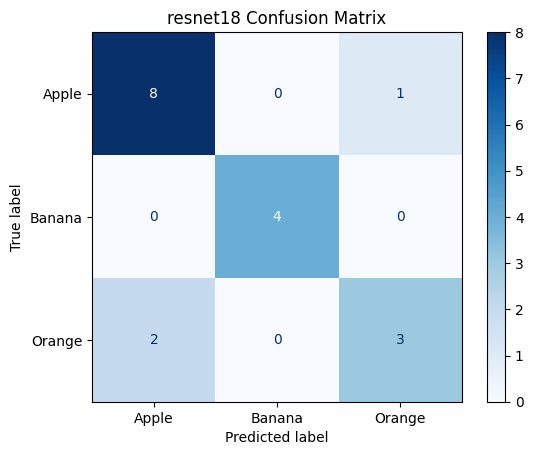


=== Analyzing efficientnet_b0 ===
Validation Accuracy: 0.222


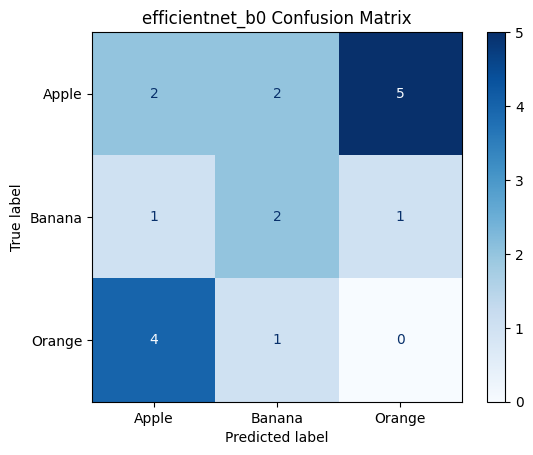

In [50]:
models_to_analyze = ["resnet18", "efficientnet_b0"]

for model_name in models_to_analyze:
    print(f"\n=== Analyzing {model_name} ===")
    cfg.model_name = model_name
    model_path = os.path.join(BASE_DIR, cfg.out_dir, f"best_model_{model_name}.pt")
    
    model = build_model(cfg)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device).eval()
    
    # Метрики
    val_acc, val_cm = evaluate_model(model, val_loader)
    print(f"Validation Accuracy: {val_acc:.3f}")
    
    # Матрица ошибок
    disp = ConfusionMatrixDisplay(val_cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

# Кривые обучения

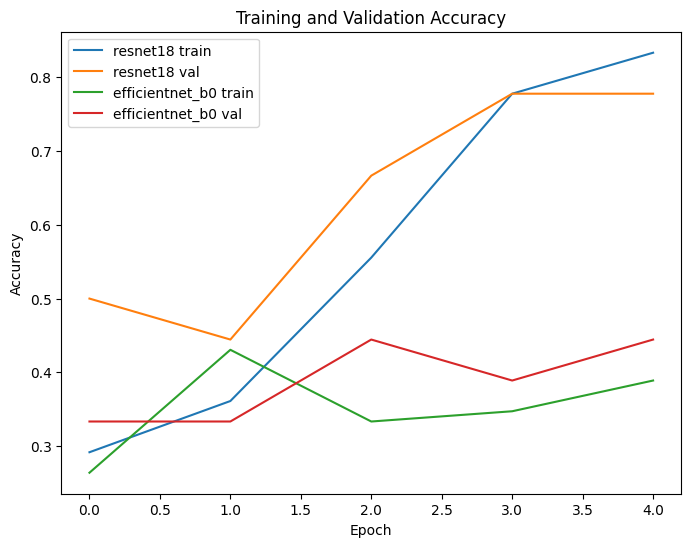

In [51]:
if history:
    plt.figure(figsize=(8,6))
    for model_name, hist in history.items():
        plt.plot(hist["train_acc"], label=f"{model_name} train")
        plt.plot(hist["val_acc"], label=f"{model_name} val")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.show()

# Экспорт в ONNX

In [52]:
best_model_name = None
best_val_acc = 0.0

for name, hist in all_history.items():
    val_best = max(hist["val_acc"])
    if val_best > best_val_acc:
        best_val_acc = val_best
        best_model_name = name

print(f"Best model: {best_model_name} (val_acc={best_val_acc:.3f})")
cfg.model_name = best_model_name

model_path = os.path.join(BASE_DIR, "outputs", f"best_model_{best_model_name}.pt")
onnx_path = os.path.join(BASE_DIR, "outputs", f"best_model.onnx")

model = build_model(cfg)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

dummy_input = torch.randn(1, 3, cfg.img_size, cfg.img_size, device=device)
torch.onnx.export(
    model,
    dummy_input,
    onnx_path,
    input_names=["input"],
    output_names=["output"],
    opset_version=18
)
print(f"Model exported to ONNX at: {onnx_path}")


Best model: resnet18 (val_acc=0.889)
[torch.onnx] Obtain model graph for `ResNet([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `ResNet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Model exported to ONNX at: c:\Users\gorko\Documents\Учеба\Нейронки\Fine Tune\outputs\best_model.onnx
